# LOFAR OPC UA single station imaging

In [1]:
import numpy as np
import os
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
from lofarantpos.db import LofarAntennaDatabase

In [12]:
from lofarimaging import make_xst_plots

In [7]:
from lofarimaging.opc_interface import download_xst

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
station_name = "RS210"
subband = 250
integration_time_s = 2

In [6]:
db = LofarAntennaDatabase()

In [9]:
%time obstime, visibilities, rcu_mode = download_xst(subband, integration_time_s)
rcu_mode

CPU times: user 18.9 ms, sys: 4.7 ms, total: 23.6 ms
Wall time: 7.57 s


0

In [10]:
obstime

datetime.datetime(2020, 3, 23, 17, 19, 6, 72752)

In [11]:
# HACK to be able to test when station is off
if rcu_mode == 0:
    print("Station is in mode 0, pretending it's in mode 3 to test")
    rcu_mode = 3

Station is in mode 0, pretending it's in mode 3 to test


In [14]:
sky_fig, ground_fig, leaflet_map = make_xst_plots(visibilities, station_name, obstime, subband, rcu_mode)

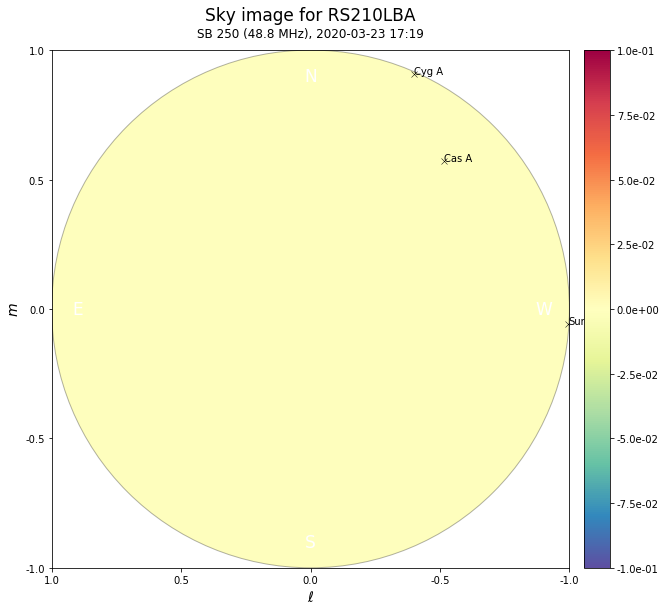

In [15]:
sky_fig

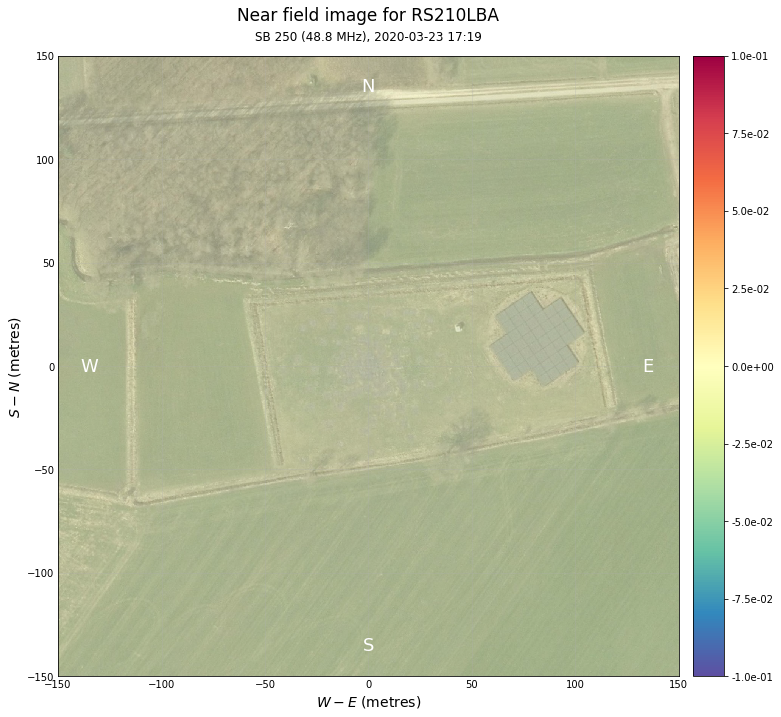

In [16]:
ground_fig

In [17]:
leaflet_map